In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 데이터 로드
file_path = '/Users/yeojoon/Documents/PyWorkspace_CreativeDesign/RAWdataSet0402.xlsx'
data = pd.read_excel(file_path, sheet_name='Tensile')

# 데이터 구조 확인
print(data.columns)

# tf 버전 확인
print("Eager execution enabled:", tf.executing_eagerly())
print(tf.__version__)


Index(['중복그룹', 'Material', 'C', 'C_Min', 'C_Max', 'Si', 'Si_Min', 'Si_Max',
       'Mn', 'Unnamed: 9', 'Unnamed: 10', 'P', 'Unnamed: 12', 'Unnamed: 13',
       'S', 'Unnamed: 15', 'Unnamed: 16', 'Cr', 'Unnamed: 18', 'Unnamed: 19',
       'Mo', 'Unnamed: 21', 'Unnamed: 22', 'B', 'Unnamed: 24', 'Unnamed: 25',
       'Ni', 'Unnamed: 27', 'Unnamed: 28', 'Al', 'Unnamed: 30', 'Unnamed: 31',
       'Cu', 'Unnamed: 33', 'Unnamed: 34', 'Nb', 'Unnamed: 36', 'Unnamed: 37',
       'V', 'Unnamed: 39', 'Unnamed: 40', 'Pb', 'Unnamed: 42', 'Unnamed: 43',
       'Ti', 'Unnamed: 45', 'Unnamed: 46', 'N', 'Unnamed: 48', 'Unnamed: 49',
       'As', 'Unnamed: 51', 'Unnamed: 52', 'Co', 'Unnamed: 54', 'Unnamed: 55',
       'Bi', 'Unnamed: 57', 'Unnamed: 58', 'Zn', 'Unnamed: 60', 'Unnamed: 61',
       'La', 'Unnamed: 63', 'Unnamed: 64', 'others', 'HeatTreatment', 'HB',
       'YS', 'TS', 'EL', 'RA', 'E', 'K', 'n', 'G', 'K0', 'n0', 'E'', 'K'',
       'n'', 'G'', 'K'o', 'n'o', 'sf', 'b', 'ef', 'c', 'tf', 'b0', '

In [8]:
# 입력 변수 및 타겟 변수 설정
X = data[['TS', 'E', 'YS', 'HB']].dropna()

# 출력 변수 (Coffin-Manson 계수)
y_tensile = data[['b', 'ef', 'c']].loc[X.index]  # b, e'f, c
y_shear = data[['b0', 'gf', 'c0']].loc[X.index]  # b0, g'f, c0

# 데이터 타입 변환
X = X.apply(pd.to_numeric, errors='coerce')
y_tensile = y_tensile.apply(pd.to_numeric, errors='coerce')
y_shear = y_shear.apply(pd.to_numeric, errors='coerce')

# 결측치 제거
valid_idx = ~(X.isna().any(axis=1) | y_tensile.isna().any(axis=1) | y_shear.isna().any(axis=1))
X = X[valid_idx]
y_tensile = y_tensile[valid_idx]
y_shear = y_shear[valid_idx]

# 데이터 정규화
scaler_X = StandardScaler()
scaler_y_tensile = StandardScaler()
scaler_y_shear = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_tensile_scaled = scaler_y_tensile.fit_transform(y_tensile)
y_shear_scaled = scaler_y_shear.fit_transform(y_shear)

# 데이터 분할
X_train, X_test, y_tensile_train, y_tensile_test, y_shear_train, y_shear_test = train_test_split(
    X_scaled, y_tensile_scaled, y_shear_scaled, test_size=0.2, random_state=42
)

# PINN 모델 구현
class CoffinMansonPINN:
    def __init__(self, input_dim=4):
        self.input_dim = input_dim
        self.tensile_model = self._build_model("tensile")
        self.shear_model = self._build_model("shear")
        
    def _build_model(self, model_type):
        inputs = Input(shape=(self.input_dim,))
        
        # 공통 레이어
        x = Dense(64, activation='relu')(inputs)
        x = Dense(32, activation='relu')(x)
        x = Dense(16, activation='relu')(x)
        
        # 출력 레이어
        if model_type == "tensile":
            outputs = Dense(3, activation='linear', name='tensile_params')(x)  # b, e'f, c
        else:
            outputs = Dense(3, activation='linear', name='shear_params')(x)    # b0, g'f, c0
            
        model = Model(inputs=inputs, outputs=outputs)
        return model
    
    def compile_models(self, learning_rate=0.0001):
        optimizer_tensile = Adam(learning_rate=learning_rate)
        optimizer_shear = Adam(learning_rate=learning_rate)
        
        self.tensile_model.compile(
            optimizer=optimizer_tensile,
            loss=self._physics_informed_loss_tensile
        )
        
        self.shear_model.compile(
            optimizer=optimizer_shear,
            loss=self._physics_informed_loss_shear
        )        

    def _physics_informed_loss_tensile(self, y_true, y_pred):
        # 데이터 기반 손실
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # 물리적 제약 조건 (Coffin-Manson 방정식)
        # 여기서는 간단한 예시로 b와 c 값의 범위에 대한 제약을 추가
        # 일반적으로 b는 -0.05~-0.15 범위, c는 -0.5~-0.7 범위에 있음
        b_pred = y_pred[:, 0]
        c_pred = y_pred[:, 2]
        
        physics_loss = tf.reduce_mean(tf.square(tf.maximum(0.0, b_pred + 0.05))) + \
                       tf.reduce_mean(tf.square(tf.maximum(0.0, -0.15 - b_pred))) + \
                       tf.reduce_mean(tf.square(tf.maximum(0.0, c_pred + 0.5))) + \
                       tf.reduce_mean(tf.square(tf.maximum(0.0, -0.7 - c_pred)))
        
        # 전체 손실 = 데이터 손실 + 물리적 손실
        return mse_loss + 0.3 * physics_loss
    
    def _physics_informed_loss_shear(self, y_true, y_pred):
        # 데이터 기반 손실
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # 물리적 제약 조건 (Coffin-Manson 방정식 - 전단 버전)
        # 전단 파라미터에 대한 제약 조건 추가
        b0_pred = y_pred[:, 0]
        c0_pred = y_pred[:, 2]
        
        physics_loss = tf.reduce_mean(tf.square(tf.maximum(0.0, b0_pred + 0.05))) + \
                       tf.reduce_mean(tf.square(tf.maximum(0.0, -0.15 - b0_pred))) + \
                       tf.reduce_mean(tf.square(tf.maximum(0.0, c0_pred + 0.5))) + \
                       tf.reduce_mean(tf.square(tf.maximum(0.0, -0.7 - c0_pred)))
        
        return mse_loss + 0.1 * physics_loss
    
    def fit(self, X_train, y_tensile_train, y_shear_train, epochs=5000, batch_size=32, validation_split=0.2):
        # 인장 모델 학습
        tensile_history = self.tensile_model.fit(
            X_train, y_tensile_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=1
        )
        
        # 전단 모델 학습
        shear_history = self.shear_model.fit(
            X_train, y_shear_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            verbose=1
        )
        
        return tensile_history, shear_history
    
    def predict(self, X):
        tensile_params = self.tensile_model.predict(X)
        shear_params = self.shear_model.predict(X)
        return tensile_params, shear_params

# PINN 모델 생성 및 컴파일
pinn_model = CoffinMansonPINN(input_dim=X_scaled.shape[1])
pinn_model.compile_models(learning_rate=0.001)

# 모델 학습
tensile_history, shear_history = pinn_model.fit(
    X_train, 
    y_tensile_train, 
    y_shear_train, 
    epochs=2000,  # 에포크 수 조정 가능
    batch_size=16,
    validation_split=0.2
)

Epoch 1/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step - loss: 1.3951 - val_loss: 2.1770
Epoch 2/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.3395 - val_loss: 2.0177
Epoch 3/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.2881 - val_loss: 1.8798
Epoch 4/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.2424 - val_loss: 1.7696
Epoch 5/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.2000 - val_loss: 1.6696
Epoch 6/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.1597 - val_loss: 1.5715
Epoch 7/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1232 - val_loss: 1.5031
Epoch 8/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.0911 - val_loss: 1.4483
Epoch 9/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.0615 - val_loss: 1.3969
Epoch 10/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 1.0328 - val_loss: 1.3493
Epoch 11/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.0069 - val_loss: 1.3047
Epoch 12/2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.

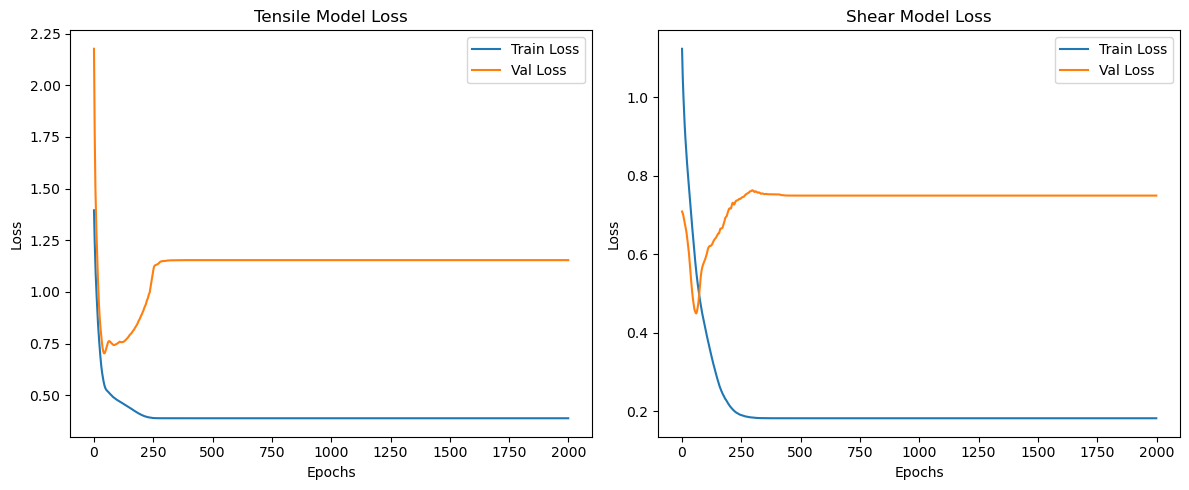

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tensile Parameters Evaluation:
b - MAE: 0.0057, RMSE: 0.0067, R²: 0.1606
e_f - MAE: 0.2781, RMSE: 0.4817, R²: 0.1102
c - MAE: 0.0510, RMSE: 0.0614, R²: 0.3631

Shear Parameters Evaluation:
b0 - MAE: 0.0037, RMSE: 0.0038, R²: 0.8677
g_f - MAE: 0.2186, RMSE: 0.3786, R²: 0.8756
c0 - MAE: 0.0155, RMSE: 0.0168, R²: 0.8571


In [9]:
# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(tensile_history.history['loss'], label='Train Loss')
plt.plot(tensile_history.history['val_loss'], label='Val Loss')
plt.title('Tensile Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(shear_history.history['loss'], label='Train Loss')
plt.plot(shear_history.history['val_loss'], label='Val Loss')
plt.title('Shear Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 테스트 데이터에 대한 예측
tensile_pred, shear_pred = pinn_model.predict(X_test)

# 역정규화
tensile_pred_orig = scaler_y_tensile.inverse_transform(tensile_pred)
tensile_test_orig = scaler_y_tensile.inverse_transform(y_tensile_test)
shear_pred_orig = scaler_y_shear.inverse_transform(shear_pred)
shear_test_orig = scaler_y_shear.inverse_transform(y_shear_test)

# 예측 결과 평가
def evaluate_predictions(y_true, y_pred, param_names):
    for i, param in enumerate(param_names):
        mae = np.mean(np.abs(y_true[:, i] - y_pred[:, i]))
        rmse = np.sqrt(np.mean((y_true[:, i] - y_pred[:, i])**2))
        r2 = 1 - np.sum((y_true[:, i] - y_pred[:, i])**2) / np.sum((y_true[:, i] - np.mean(y_true[:, i]))**2)
        print(f"{param} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

print("Tensile Parameters Evaluation:")
evaluate_predictions(tensile_test_orig, tensile_pred_orig, ['b', 'e_f', 'c'])

print("\nShear Parameters Evaluation:")
evaluate_predictions(shear_test_orig, shear_pred_orig, ['b0', 'g_f', 'c0'])

In [10]:

# Coffin-Manson 방정식 구현
def coffin_manson_tensile(N, params, E):
    b, e_f, c = params
    elastic_strain = (params[0] * E) * np.power(2 * N, b)  # σf'/E * (2N)^b
    plastic_strain = e_f * np.power(2 * N, c)              # εf' * (2N)^c
    return elastic_strain + plastic_strain

def coffin_manson_shear(N, params, G):
    b0, g_f, c0 = params
    elastic_strain = (params[0] * G) * np.power(2 * N, b0)  # τf'/G * (2N)^b0
    plastic_strain = g_f * np.power(2 * N, c0)              # γf' * (2N)^c0
    return elastic_strain + plastic_strain

# 예측 파라미터를 사용한 E-N 곡선 생성 함수
def predict_params(uts, e, ys, hb):
    """UTS, E, YS, HB를 기반으로 Coffin-Manson 계수 예측"""
    input_data = np.array([[uts, e, ys, hb]])
    input_scaled = scaler_X.transform(input_data)
    
    tensile_params_scaled, shear_params_scaled = pinn_model.predict(input_scaled)
    tensile_params = scaler_y_tensile.inverse_transform(tensile_params_scaled)[0]
    shear_params = scaler_y_shear.inverse_transform(shear_params_scaled)[0]
    
    params = {
        'b': float(tensile_params[0]),
        'e_f': float(tensile_params[1]),
        'c': float(tensile_params[2]),
        'b0': float(shear_params[0]),
        'g_f': float(shear_params[1]),
        'c0': float(shear_params[2]),
    }
    
    # Roessle-Fatemi 방정식으로 추가 계수 계산
    # 인장 피로 강도 계수 (σf')
    params['sigma_f'] = 1.5 * uts
    
    # 포아송 비 (일반적으로 금속은 약 0.3)
    nu = 0.3
    
    # 전단 탄성 계수 (G)
    params['G'] = e / (2 * (1 + nu))
    
    # 전단 피로 강도 계수 (τf')
    # UTS에 따라 von Mises 또는 Max Principal Stress 기준 사용
    if uts <= 1100:  # 연성 재료
        params['tau_f'] = params['sigma_f'] / np.sqrt(3)  # von Mises 기준
    elif uts >= 1696:  # 취성 재료
        params['tau_f'] = params['sigma_f'] / 2  # Max Principal Stress 기준
    else:  # 중간 영역
        w = (uts - 1100) / (1696 - 1100)  # 가중치 (0~1)
        tau_f_ductile = params['sigma_f'] / np.sqrt(3)
        tau_f_brittle = params['sigma_f'] / 2
        params['tau_f'] = tau_f_ductile * (1-w) + tau_f_brittle * w
    
    params['E'] = e  # 영 계수 저장
    
    return params

def generate_en_curves(params, n_values):
    """Coffin-Manson 방정식으로 E-N 곡선 생성"""
    # 인장 E-N 곡선
    elastic_strain_tensile = (params['sigma_f'] / params['E']) * np.power(2 * n_values, params['b'])
    plastic_strain_tensile = params['e_f'] * np.power(2 * n_values, params['c'])
    total_strain_tensile = elastic_strain_tensile + plastic_strain_tensile
    
    # 전단 E-N 곡선
    elastic_strain_shear = (params['tau_f'] / params['G']) * np.power(2 * n_values, params['b0'])
    plastic_strain_shear = params['g_f'] * np.power(2 * n_values, params['c0'])
    total_strain_shear = elastic_strain_shear + plastic_strain_shear
    
    return {
        'tensile': {
            'elastic': elastic_strain_tensile,
            'plastic': plastic_strain_tensile,
            'total': total_strain_tensile
        },
        'shear': {
            'elastic': elastic_strain_shear,
            'plastic': plastic_strain_shear,
            'total': total_strain_shear
        }
    }

def plot_en_curves(uts, e, ys, hb):
    """UTS, E, YS, HB를 입력받아 E-N 곡선 생성 및 시각화"""
    # Coffin-Manson 계수 예측
    params = predict_params(uts, e, ys, hb)
    
    # 사이클 수 범위 생성 (10^1 ~ 10^8)
    n_values = np.logspace(1, 8, 100)
    
    # E-N 곡선 생성
    curves = generate_en_curves(params, n_values)
    
    # 그래프 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    
    # 인장 E-N 곡선
    ax1.loglog(n_values, curves['tensile']['elastic'], 'b--', alpha=0.7, label='Elastic')
    ax1.loglog(n_values, curves['tensile']['plastic'], 'g--', alpha=0.7, label='Plastic')
    ax1.loglog(n_values, curves['tensile']['total'], 'r-', linewidth=2, label='Total')
    ax1.set_xlabel('Number of Cycles, N')
    ax1.set_ylabel('Strain Amplitude, Δε/2')
    ax1.set_title('Tensile Fatigue Life E-N Curve')
    ax1.grid(True, which='both', linestyle='--', alpha=0.7)
    ax1.legend()
    
    # 인장 매개변수 표시
    param_text = (f"UTS = {uts} MPa\n"
                 f"E = {e:.1f} GPa\n"
                 f"σ_f' = {params['sigma_f']:.1f} MPa\n"
                 f"b = {params['b']:.4f}\n"
                 f"ε_f' = {params['e_f']:.4f}\n"
                 f"c = {params['c']:.4f}")
    ax1.text(0.05, 0.95, param_text, transform=ax1.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 전단 E-N 곡선
    ax2.loglog(n_values, curves['shear']['elastic'], 'b--', alpha=0.7, label='Elastic')
    ax2.loglog(n_values, curves['shear']['plastic'], 'g--', alpha=0.7, label='Plastic')
    ax2.loglog(n_values, curves['shear']['total'], 'r-', linewidth=2, label='Total')
    ax2.set_xlabel('Number of Cycles, N')
    ax2.set_ylabel('Shear Strain Amplitude, Δγ/2')
    ax2.set_title('Shear Fatigue Life E-N Curve')
    ax2.grid(True, which='both', linestyle='--', alpha=0.7)
    ax2.legend()
    
    # 전단 매개변수 표시
    param_text = (f"G = {params['G']:.1f} GPa\n"
                 f"τ_f' = {params['tau_f']:.1f} MPa\n"
                 f"b₀ = {params['b0']:.4f}\n"
                 f"γ_f' = {params['g_f']:.4f}\n"
                 f"c₀ = {params['c0']:.4f}")
    ax2.text(0.05, 0.95, param_text, transform=ax2.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    return params, curves

In [11]:
def main():
    """메인 프로그램"""
    print("E-N Curve Prediction Program")
    print("----------------------------")
    
    try:
        # 사용자 입력
        uts = float(input("Ultimate Tensile Strength (UTS) in MPa: "))
        e = float(input("Young's Modulus (E) in GPa: "))
        ys = float(input("Yield Strength (YS) in MPa: "))
        hb = float(input("Brinell Hardness (HB): "))
        
        # E-N 곡선 생성 및 시각화
        params, curves = plot_en_curves(uts, e, ys, hb)
        
        # 예측된 매개변수 출력
        print("\nPredicted Coffin-Manson Parameters:")
        print(f"Tensile: σf' = {params['sigma_f']:.1f} MPa, b = {params['b']:.4f}, "
              f"εf' = {params['e_f']:.4f}, c = {params['c']:.4f}")
        print(f"Shear: τf' = {params['tau_f']:.1f} MPa, b₀ = {params['b0']:.4f}, "
              f"γf' = {params['g_f']:.4f}, c₀ = {params['c0']:.4f}, G = {params['G']:.1f} GPa")
        
    except ValueError:
        print("Error: 유효한 숫자를 입력해주세요.")

데이터 로드 및 전처리 중...
PINN 모델 생성 중...
모델 학습 중...
Epoch 1/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step - loss: 1.2972 - val_loss: 1.5102
Epoch 2/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.2607 - val_loss: 1.4481
Epoch 3/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.2302 - val_loss: 1.4012
Epoch 4/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.2020 - val_loss: 1.3612
Epoch 5/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.1753 - val_loss: 1.3235
Epoch 6/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.1503 - val_loss: 1.2881
Epoch 7/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.1277 - val_loss: 1.2573
Epoch 8/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.1085 - val_loss: 1.2291
Epoch 9/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0911 - val_loss: 1.2017
Epoch 10/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.0753 - val_loss: 1.1759
Epoch 11/5000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.0602 - val_loss: 1.1526
Epoch 12/5000
1/1

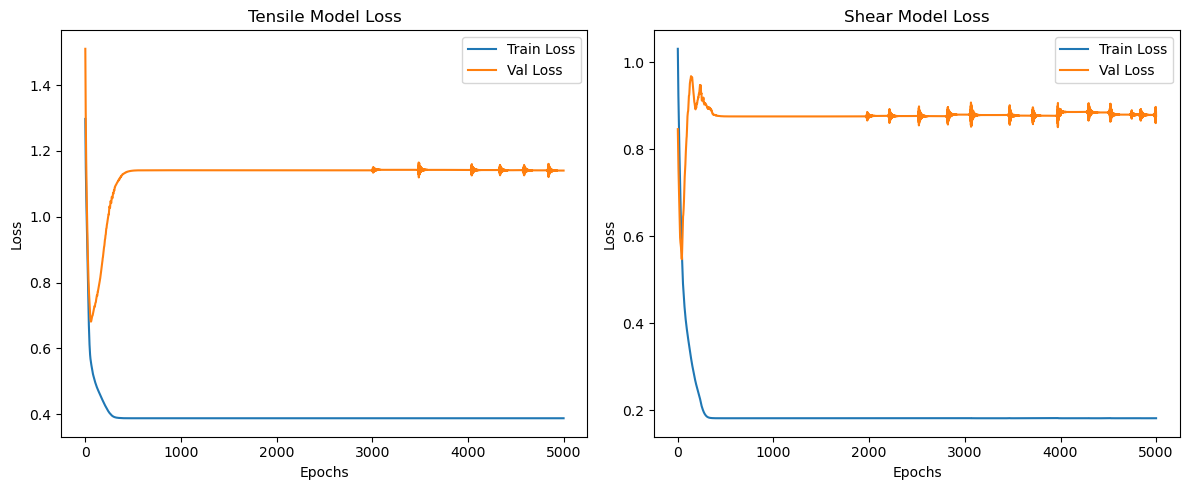

테스트 데이터에 대한 모델 평가 중...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tensile Parameters Evaluation:
b - MAE: 0.0131, RMSE: 0.0190, R²: -5.7965
e_f - MAE: 0.3999, RMSE: 0.6927, R²: -0.8398
c - MAE: 0.0370, RMSE: 0.0398, R²: 0.7323

Shear Parameters Evaluation:
b0 - MAE: 0.0031, RMSE: 0.0031, R²: 0.9122
g_f - MAE: 0.2400, RMSE: 0.4153, R²: 0.8502
c0 - MAE: 0.0156, RMSE: 0.0170, R²: 0.8551
E-N Curve Prediction Program
----------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


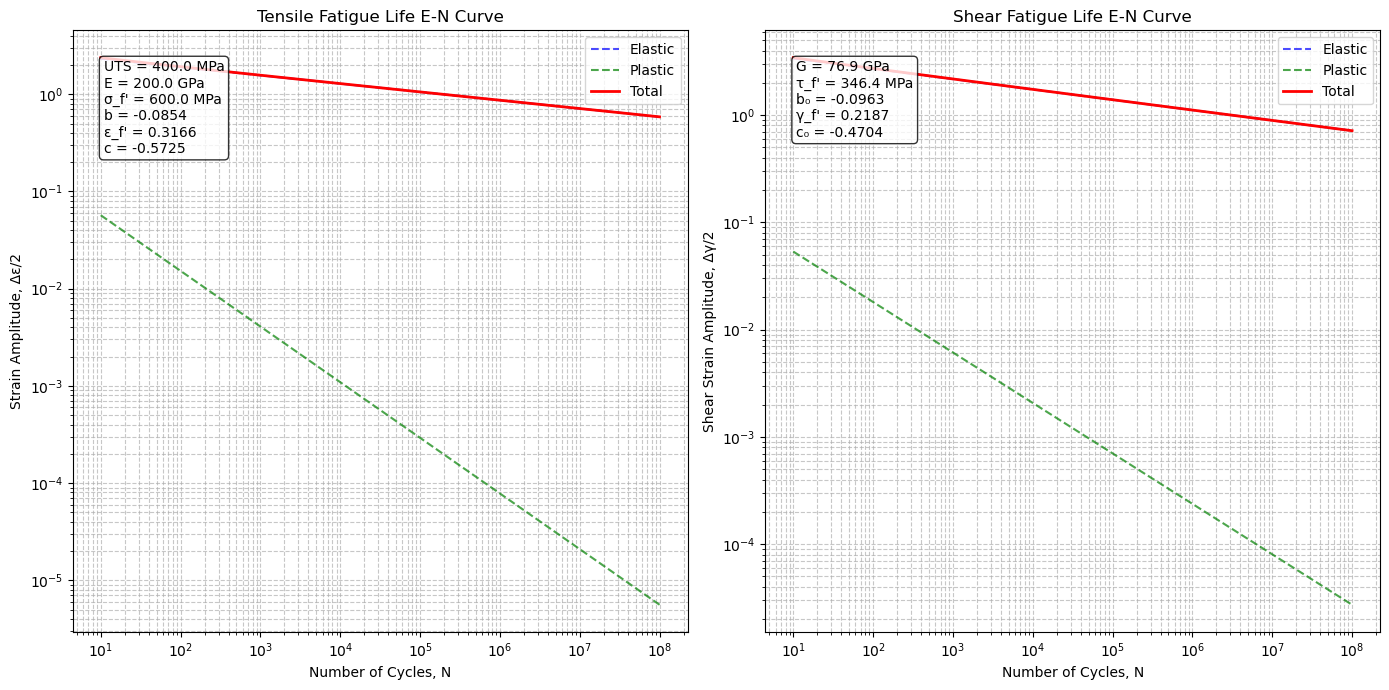


Predicted Coffin-Manson Parameters:
Tensile: σf' = 600.0 MPa, b = -0.0854, εf' = 0.3166, c = -0.5725
Shear: τf' = 346.4 MPa, b₀ = -0.0963, γf' = 0.2187, c₀ = -0.4704, G = 76.9 GPa


In [12]:
if __name__ == "__main__":
    # 모델 학습 및 평가
    # 1. 데이터 준비
    print("데이터 로드 및 전처리 중...")
    
    # 2. PINN 모델 생성 및 학습
    print("PINN 모델 생성 중...")
    pinn_model = CoffinMansonPINN(input_dim=X_scaled.shape[1])
    pinn_model.compile_models(learning_rate=0.001)
    
    print("모델 학습 중...")
    tensile_history, shear_history = pinn_model.fit(
        X_train, 
        y_tensile_train, 
        y_shear_train, 
        epochs=5000,
        batch_size=16,
        validation_split=0.2
    )
    
    # 3. 학습 결과 시각화
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(tensile_history.history['loss'], label='Train Loss')
    plt.plot(tensile_history.history['val_loss'], label='Val Loss')
    plt.title('Tensile Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(shear_history.history['loss'], label='Train Loss')
    plt.plot(shear_history.history['val_loss'], label='Val Loss')
    plt.title('Shear Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4. 테스트 데이터에 대한 평가
    print("테스트 데이터에 대한 모델 평가 중...")
    tensile_pred, shear_pred = pinn_model.predict(X_test)
    tensile_pred_orig = scaler_y_tensile.inverse_transform(tensile_pred)
    tensile_test_orig = scaler_y_tensile.inverse_transform(y_tensile_test)
    shear_pred_orig = scaler_y_shear.inverse_transform(shear_pred)
    shear_test_orig = scaler_y_shear.inverse_transform(y_shear_test)
    
    print("Tensile Parameters Evaluation:")
    evaluate_predictions(tensile_test_orig, tensile_pred_orig, ['b', 'e_f', 'c'])
    
    print("\nShear Parameters Evaluation:")
    evaluate_predictions(shear_test_orig, shear_pred_orig, ['b0', 'g_f', 'c0'])
    
    # 5. 사용자 입력을 통한 예측 수행
    main()
